<img align="center" src="figures/course.png" width="800">

#                                    16720 (B) Bag of Visual Words - Assignment 2

     Instructor: Kris Kitani                   TAs: Sheng-Yu, Jinkun, Rawal, Arka, Rohan

In [3]:
import nbimporter
import numpy as np
import scipy.ndimage
from skimage import io
import skimage.transform
import os,time
import util
import multiprocess
import threading
import queue
import torch
import torchvision
import torchvision.transforms

## For Autograding P4, ensure uploading `trained_conf_matrix.npy` and `trained_system_deep.npz`. 

## For extra credit, ensure uploading `trained_conf_matrix_vit.npy` and `trained_system_vit.npz`.

### Deep Learning Features - An Alternative to ``Bag of Words``

As we have discussed in class, another powerful method for scene classification in computer vision is the employment of convolutional neural networks (CNNs) - sometimes referred to generically as $deep learning$. It is important to understand how previously trained (pretrained) networks can be used as another form of feature extraction, and how they relate to classical Bag of Words (BoW) features. We will be covering details on how one chooses the network architecture and training procedures later in the course. For this question, however, we will be asking you to deal with the VGG-16 pretrained network. VGG-16 is a pretrained Convolutional Neural Network (CNN) that has been trained on approximately 1.2 million images from the ImageNet Dataset (``http://image-net.org/index``) by the Visual Geometry Group (VGG) at University of Oxford. The model can classify images into a 1000 object categories (e.g. keyboard, mouse, coffee mug, pencil).

One lesson we want you to take away from this exercise is to understand the effectiveness of $deep$ $features$ for general classification tasks within computer vision - even when those features have been previously trained on a different dataset (i.e. ImageNet) and task (i.e. object recognition). 

#### Extracting Deep Features

To complete this question, you need to install the ``torchvision`` library from Pytorch, a popular Python-based deep learning library.
If you are using the Anaconda package manager (``https://www.anaconda.com/download/``), this can be done with the following command:
```
            conda install pytorch torchvision -c pytorch
```
To check that you have installed it correctly, make sure that you can ``import torch`` in a Python interpreter without errors.
Please refer to ``https://pytorch.org/`` for more detailed installation instructions. 

#### Q4.1.1 (25 Points)

We want to extract out deep features corresponding to the convolutional layers of theVGG-16 network.  In this problem, we will use the trained weights from the VGG network directly, but implement our own operations. To load the network, use the line
```
        vgg16 = torchvision.models.vgg16(pretrained=True).double()
```
followed by ``vgg16.eval()``
The latter line ensures that the VGG-16 network is in evaluation mode, not training mode.

path_img = "./data/aquarium/sun_aztvjgubyrgvirup.jpg"

image = io.imread(path_img)

image = image.astype('float')/255

vgg16 = torchvision.models.vgg16(pretrained=True).double()

vgg16.eval()

We want you to complete a function that is able to output $VGG-16$ network outputs at the **fc7** layer in
```
    def extract_deep_feature(x,vgg16_weights):
```
where ``x`` refers to the input image and ``vgg16_weights`` is a structure containing the CNN's network parameters. In this function you will need to write sub-functions ``multichannel_conv2d``, ``relu``, ``max_pool2d``, and ``linear`` corresponding to the fundamental elements of the CNN: multi-channel convolution, rectified linear units (ReLU), max pooling, and fully-connected weighting.

We have provided a helper function ``util.get_VGG16_weights()`` that extracts the weight parameters of VGG-16 and its meta information. The returned variable is a numpy array of shape $L\times 3$, where $L$ is the number of layers in VGG-16. The first column of each row is a string indicating the layer type. The second/third columns may contain the learned weights and biases, or other meta-information (\eg kernel size of max-pooling). Please refer to the function docstring for details.

In order to build the ``extract_deep_feature`` function, you should run a for-loop through each layer index until layer **fc7**, which corresponds to **the second linear layer** (Refer to VGG structure to see where **fc7** is). **Remember**: the output of the preceding layer should be passed through as an input to the next.

Details on the sub-functions needed for the ``extract_deep_feature`` function can be found below.

Please use ``scipy.ndimage.convolve`` and ``numpy`` functions to implement these functions instead of using pytorch. Please keep speed in mind when implementing your function, for example, using double for loop over pixels is not a good idea.

``multichannel_conv2d(x,weight,bias)``:

a function that will perform multi-channel 2D convolution which can be defined as follows, 

\begin{equation}
\mathbf{y}^{(j)} = \sum_{k=1}^{K} \begin{bmatrix} \mathbf{x}^{(k)} * \mathbf{h}^{(j,k)} \end{bmatrix} + \mathbf{b}[j] 
\end{equation}

where $*$ denotes $2D$ convolution, $\mathbf{x} = \{ \mathbf{x}^{(k)} \}_{k=1}^{K}$ is our vectorized $K$-channel input signal, $\mathbf{h} = \{ \mathbf{h}^{(j,k)} \}_{k=1,j=1}^{K,J}$ is our $J \times K$ set of vectorized convolutional filters and $\mathbf{r} = \{ \mathbf{y}^{(j)} \}_{j=1}^{J}$ is our $J$ channel vectorized output response. Further, unlike traditional single-channel convolution CNNs often append a bias vector $\mathbf{b}$ whose $J$ elements are added to the $J$ channels of the output response. 

To implement ``multichannel_conv2d``, you can use the Scipy convolution function directly with for loops to cycle through the filters and channels (``scipy.ndimage.convolve()``). All the necessary details concerning the number of filters ($J$), number of channels ($K$), filter weights ($\mathbf{h}$) and biases ($\mathbf{b}$) can be inferred from the shapes/dimensions of the weights and biases. Notice that pytorch's convolution function actually does correlation, so to get similar answer as pytroch with scipy, you need to flip the kernel on both axes using ``np.flip()``.

In [6]:
def multichannel_conv2d(x,weight,bias):
    '''
    Performs multi-channel 2D convolution.

    [input]
    * x: numpy.ndarray of shape (H,W,input_dim)
    * weight: numpy.ndarray of shape (output_dim,input_dim,kernel_size,kernel_size)
    * bias: numpy.ndarray of shape (output_dim)

    [output]
    * feat: numpy.ndarray of shape (H,W,output_dim)
    '''
    h, w, input_dims = x.shape
    output_dims = weight.shape[0] # no of kernels
    final_res = np.zeros((h, w, output_dims))
    '''
    HINTS:
    1.> for 2D convolution we need to use np.fliplr and np.flipud
    2.> can use scipy.ndimage.convolve with the flipped kernel
    3.> don't forget to add the bias
    '''
    # YOUR CODE HERE
    for i in range(output_dims):
        for j in range(input_dims):
            kernel = weight[i,j,:,:]
            kernel = np.flipud(np.fliplr(kernel))
            per_channel_per_filter_op = scipy.ndimage.convolve(x[:,:,j], kernel, mode='constant', cval=0.0) # (h.w)
            final_res[:,:,i]+=per_channel_per_filter_op
        final_res[:,:,i]+=bias[i]
        
        
    # raise NotImplementedError()
    return final_res

```relu(x)```:

a function that shall perform the Rectified Linear Unit (ReLU) which can be defined mathematically as,

\begin{equation}
\mbox{ReLU}(x) = \max_{x}(x, 0)
\end{equation}

and is applied independently to each element of the matrix/vector $x$ passed to it.

In [7]:
def relu(x):
    '''
    Rectified linear unit.

    [input]
    * x: numpy.ndarray

    [output]
    * y: numpy.ndarray
    '''
    # YOUR CODE HERE
    y = np.maximum(x, np.zeros_like(x))
    # raise NotImplementedError()
    return y


``max_pool2d(x,size):``

a function that shall perform max pooling over $x$ using a receptive field of size $size$ $\times$ $size$ (we assume a square receptive field here for simplicity).

  If the function receives a multi-channel input, then it should apply the max pooling operation across each input channel independently.
  
(Hint: making use of smart array indexing can drastically speed up the code.)

In [8]:
def max_pool2d(x,size):
    '''
    2D max pooling operation.

    [input]
    * x: numpy.ndarray of shape (H,W,input_dim)
    * size: pooling receptive field

    [output]
    * y: numpy.ndarray of shape (H/size,W/size,input_dim)
    '''
    h, w, dims = x.shape
    '''
    HINTS:
    1.> estimate the shape you need to apply the pooling operation.
    2.> We can smart fill the padding with np.nan and then use np.nanmax to select the max (avoiding nan)
    3.> We can input the grid (start_x:end_x, start_y:end_y, dim) as smart array indexing to np.nanmax
    '''
    # YOUR CODE HERE
    # print("x shape:", str(x.shape))
    if h%size==0:
        new_h = int(h/size)
        pad_h = 0
    else:
        # print('here')
        new_h = int(h//size) + 1
        pad_h = int(size - h%size)
    if w%size==0:
        new_w = int(w/size)
        pad_w = 0
    else:
        # print('here')
        new_w = int(w//size) + 1
        pad_w = int(size - w%size)

    pooled_arr = np.zeros((new_w, new_h, dims))

     
    for i in range(dims):
        x_padded = np.pad(x[:,:,i], ((0, pad_h), (0, pad_w)), 'constant', constant_values = np.nan)
        k = 0
        for m in range(0, x_padded.shape[0], size):
            l=0
            for n in range(0, x_padded.shape[1], size):
                pooled_arr[k, l, i] = np.nanmax(x_padded[m:m+size, n:n+size])

                l+=1
            k+=1
    # raise NotImplementedError()
    # print("x shape after maxpool:", str(pooled_arr.shape))
    
    return pooled_arr

``linear(x,W,b):``

a function that will compute a node vector where each element is a linear combination of the input nodes, written as

\begin{equation}
\mathbf{y}[j] = \sum_{k=1}^{K}\mathbf{W}[j,k] \mathbf{x}[k] + \mathbf{b}[j] 
\end{equation}

or more succinctly in vector form as $\mathbf{y} = \mathbf{W} \mathbf{x} + \mathbf{b}$ - where $\mathbf{x}$ is the $(K \times 1)$ input node vector, $\mathbf{W}$ is the $(J \times K)$ weight matrix, $\mathbf{b}$ is the $(J \times 1)$ bias vector and $\mathbf{y}$ is the~$(J \times 1)$ output node vector.

You should not need for-loops to implement this function.

In [9]:
def linear(x,W,b):
    '''
    Fully-connected layer.

    [input]
    * x: numpy.ndarray of shape (input_dim)
    * weight: numpy.ndarray of shape (output_dim,input_dim)
    * bias: numpy.ndarray of shape (output_dim)

    [output]
    * y: numpy.ndarray of shape (output_dim)
    '''
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    # print(W.shape) # (4096, 25088)
    # print(x.shape) # (7, 7, 512)
    # print(b.shape) # (4096,)
    # print(np.matmul(W, x.flatten()).shape)
    # print(x.shape)
    try:
        x = np.transpose(x, (2,0,1)).flatten() # some layers pass a flattened array; also need to transpose before flattening
                                               # to match vgg features order
    except:
        # print(x.shape)
        pass
    y = np.matmul(W,x) + b
    return y

You should ignore all ``DropoutLayer`` you encounter; they're functional only during the training phase.

VGG-16 assumes that all input imagery to the network is resized to $224 \times 224$ with the three color channels preserved (use ``skimage.transform.resize()`` to do this before passing any imagery to the network). And be sure to normalize the image using suggested mean and std before extracting the feature:
```
                                        mean=[0.485,0.456,0.406]}
                                        std=[0.229,0.224,0.225]}
```

In [10]:
def preprocess_image(image):
    '''
    Preprocesses the image to load into the prebuilt network.

    [input]
    * image: numpy.ndarray of shape (H,W,3)

    [output]
    * image_processed: torch.array of shape (3,H,W)
    '''

    # ----- TODO -----
    
    if(len(image.shape) == 2):
        image = np.stack((image, image, image), axis=-1)

    if(image.shape == 3 and image.shape[2] == 1):
        image = np.concatenate((image, image, image), axis=-1)

    if(image.shape[2] == 4):
        image = image[:, :, 0:3]
    '''
    HINTS:
    1.> Resize the image (look into skimage.transform.resize)
    2.> normalize the image
    3.> convert the image from numpy to torch
    '''
    # YOUR CODE HERE
    mean=[0.485,0.456,0.406]
    std=[0.229,0.224,0.225]
    image_resized = skimage.transform.resize(image, (224, 224))
    channels = image.shape[2]
    channels_normalized = []
    for c in range(channels):
        # print(image_resized[:,:,c])
        pix_norm = (image_resized[:,:,c]-mean[c])/std[c]
        # print(pix_norm)
        channels_normalized.append(pix_norm)
    
    # print(len(channels_normalized))
    # for channel in channels_normalized:
    #     channel = skimage.transform.resize(channel, (224,224))
    image_processed = np.stack((channels_normalized))
    image_processed = torch.from_numpy(image_processed)

    # raise NotImplementedError()
    return image_processed

For efficiency you should check that each sub-function is working properly before putting them all together - otherwise it will be hard to track any errors. To compare your implementation with pytroch, you should compare the extracted features between your ``extract_deep_feature``  and the pre-trained VGG-16 network.  ``evaluate_deep_extractor`` should come in handy in comparing the result of the two extracted features.

In [4]:
def extract_deep_feature(x, vgg16_weights):
    '''
    Extracts deep features from the given VGG-16 weights.

    [input]
    * x: numpy.ndarray of shape (H,W,3)
    * vgg16_weights: list of shape (L,3)

    [output]
    * feat: numpy.ndarray of shape (K)
    '''
    
    feat = np.copy(x)
    # YOUR CODE HERE
    linear_count = 0
    for layer in vgg16_weights:
        name = layer[0]
        if name=="conv2d":
            _, weight, bias = layer
            feat = multichannel_conv2d(feat,weight,bias)
        elif name=="relu":
            feat = relu(feat)
        elif name=="maxpool2d":
            _, k_size = layer
            feat = max_pool2d(feat, k_size)
        elif name=="linear":
            _, weight, bias = layer
            feat = linear(feat, weight, bias)
            linear_count+=1
        else:
            continue
        
        if linear_count==2:
            break
        

    # raise NotImplementedError()
    return feat

In [5]:
def evaluate_deep_extractor(img, vgg16):
    '''
    Evaluates the deep feature extractor for a single image.

    [input]
    * image: numpy.ndarray of shape (H,W,3)
    * vgg16: prebuilt VGG-16 network.

    [output]
    * diff: difference between the two feature extractor's result
    '''
    
    vgg16_weights = util.get_VGG16_weights()
    img_torch = preprocess_image(img)
    # print(img_torch.shape)
    # print(np.transpose(img_torch.numpy(), (1,2,0)).shape)
    feat = extract_deep_feature(np.transpose(img_torch.numpy(), (1,2,0)), vgg16_weights)
    
    with torch.no_grad():
        vgg_classifier = torch.nn.Sequential(*list(vgg16.classifier.children())[:-3])
        vgg_feat_feat = vgg16.features(img_torch[None, ])
        vgg_feat_feat = vgg_classifier(vgg_feat_feat.flatten())
    
    return np.sum(np.abs(vgg_feat_feat.numpy() - feat))

In [13]:
# NOTE: comment out the lines below before submitting to gradescope
# Visible test cases (for debugging)
path_img = "./data/aquarium/sun_aztvjgubyrgvirup.jpg"
image = io.imread(path_img)
image = image.astype('float') / 255

vgg16 = torchvision.models.vgg16(pretrained=True).double()
vgg16.eval()
error = evaluate_deep_extractor(image, vgg16)

# This error should be less than 1e-10
print("Error:", error)

Error: 4.498847475109535e-12


### Building a Visual Recognition System: Revisited

We want to compare how useful deep features are in a visual recognition system. Since the speed of the function ``` scipy.ndimage.convolve``` is not ideal, you can use the pytroch VGG-16 network directly (refer to the helper function ```evaluate_deep_extractor``` on how to use the pre-trained network as feature extractor).

#### Q4.2.1 (5 Points Autograder + WriteUp):
Implement the functions
```
                    def build_recognition_system(vgg16):
```
and
```
                    def eval_recognition_system(vgg16)}
```
both of which takes the pretrained VGG-16 network as the input arguments. 

The former function should produce ``trained_system_deep.npz`` as the output. 

Included will be:
* $features$ : a $N \times  K$ matrix containing all the deep features of the $N$ training images in the data set.
* $labels$ : an $N$ vector containing the labels of each of the images. ($features[i]$ will correspond to label $labels[i]$).

The latter function should produce the confusion matrix, as with the previous question.

Instead of using the histogram intersection similarity, write a function to just use the negative Euclidean distance (as larger values are more similar).

**Report the confusion matrix and accuracy for your results in your write-up. Can you comment in your writeup on whether the results are better or worse than classical BoW - why do you think that is?**

In [14]:
def get_image_feature(args):
    '''
    Extracts deep features from the prebuilt VGG-16 network.
    This is a function run by a subprocess.
    [input]
    * i: index of training image
    * image_path: path of image file
    * vgg16: prebuilt VGG-16 network.
    
    [output]
    * feat: evaluated deep feature
    '''
    i, image_path, vgg16 = args
    image = io.imread(image_path) / 255
    
    '''
    HINTS:
    1.> Think along the lines of evaluate_deep_extractor
    '''
    # ----- TODO -----
    # YOUR CODE HERE
    vgg16_weights = util.get_VGG16_weights() # NOT REQUIRED, MODEL ALREADY PASSED AS ARGUMENT
    img_torch = preprocess_image(image)
    # print(img_torch.shape)
    # print(np.transpose(img_torch.numpy(), (1,2,0)).shape)
    # feat = extract_deep_feature(np.transpose(img_torch.numpy(), (1,2,0)), vgg16_weights)
    
    with torch.no_grad():
        vgg_classifier = torch.nn.Sequential(*list(vgg16.classifier.children())[:-3])
        vgg_feat_feat = vgg16.features(img_torch[None, ])
        vgg_feat_feat = vgg_classifier(vgg_feat_feat.flatten())
    
    # return np.sum(np.abs(vgg_feat_feat.numpy() - feat))
    # raise NotImplementedError()
    feat = vgg_feat_feat.numpy()
    return [i,feat]

In [20]:
# from tqdm import tqdm
def build_recognition_system(vgg16, num_workers=8):
    '''
    Creates a trained recognition system by generating training features from all training images.

    [input]
    * vgg16: prebuilt VGG-16 network.
    * num_workers: number of workers to process in parallel

    [saved]
    * features: numpy.ndarray of shape (N,K)
    * labels: numpy.ndarray of shape (N)
    '''

    train_data = np.load("./data/train_data.npz", allow_pickle=True)
    '''
    HINTS:
    1.> Similar approach as Q1.2.2 and Q3.1.1 (create an argument list and use multiprocessing)
    2.> Keep track of the order in which input is given to multiprocessing
    '''
    # YOUR CODE HERE
    # train_data = np.load("./data/train_data.npz")
    # for f in train_data.files:
    #     print(f)
    labels = train_data['labels'] #(N,)
    list_of_args = []
    image_names = train_data['files']
    num_images = image_names.shape[0]

    for i in range(num_images):
        full_image_name = './data/' + image_names[i]
        list_of_args.append([i, full_image_name, vgg16])
    
    # print(num_images)
    # compute_dictionary_one_image(list_of_args[0])
    # f_name = 'tmp/00000.npy'
    # filter_response = np.load(f_name)
    # print(filter_response.shape)
    
    # with multiprocess.Pool(num_workers) as p:
    #     features_list = p.map(get_image_feature, list_of_args)
    features_list = []
    for arg in list_of_args:
        features_list.append(get_image_feature(arg))
    print(len(features_list))
    # raise NotImplementedError()
    # ordered_features = [None] * len(features)
    
    '''
    HINTS:
    1.> reorder the features to their correct place as input
    '''
    # YOUR CODE HERE
    # raise NotImplementedError()
    ordered_features = [feature for [idx, feature] in sorted(features_list, key = lambda x: x[0])]
    # print("done", ordered_features.shape)
    
    np.savez('trained_system_deep.npz', features=ordered_features, labels=labels)

In [27]:
def evaluate_test_image(args):
    # YOUR CODE HERE
    i, image_path, vgg16, trained_features, train_labels = args
    image = io.imread(image_path) / 255
    
    '''
    HINTS:
    1.> Think along the lines of evaluate_deep_extractor
    '''
    # ----- TODO -----
    # YOUR CODE HERE
    vgg16_weights = util.get_VGG16_weights()
    img_torch = preprocess_image(image)
    # print(img_torch.shape)
    # print(np.transpose(img_torch.numpy(), (1,2,0)).shape)
    # feat = extract_deep_feature(np.transpose(img_torch.numpy(), (1,2,0)), vgg16_weights)
    
    with torch.no_grad():
        vgg_classifier = torch.nn.Sequential(*list(vgg16.classifier.children())[:-3])
        vgg_feat_feat = vgg16.features(img_torch[None, ])
        vgg_feat_feat = vgg_classifier(vgg_feat_feat.flatten())
    
    # return np.sum(np.abs(vgg_feat_feat.numpy() - feat))
    # raise NotImplementedError()
    N = trained_features.shape[0]
    feat = vgg_feat_feat.numpy() #(K,)
    feat_repeated = np.stack(([feat]*N)) # (N, K)
    distances = np.linalg.norm((feat_repeated-trained_features), axis=1)
    idx_min = np.argmin(distances)
    
    # raise NotImplementedError()
    pred_label = train_labels[idx_min]
    return [i, pred_label]


def evaluate_recognition_system(vgg16, num_workers=8):
    '''
    Evaluates the recognition system for all test images and returns the confusion matrix.

    [input]
    * vgg16: prebuilt VGG-16 network.
    * num_workers: number of workers to process in parallel

    [output]
    * conf: numpy.ndarray of shape (8,8)
    * accuracy: accuracy of the evaluated system
    '''
    '''
    HINTS:
    (1) Students can write helper functions (in this cell) to use multi-processing
    '''
    test_data = np.load("./data/test_data.npz", allow_pickle=True)

    # ----- TODO -----
    trained_system = np.load("trained_system_deep.npz", allow_pickle=True)
    image_names = test_data['files']
    test_labels = test_data['labels']

    trained_features = trained_system['features']
    train_labels = trained_system['labels']

    print("Trained features shape: ", trained_features.shape)
    
    '''
    HINTS:
    1.> [Important] Can write a helper function in this cell of jupyter notebook for multiprocessing
    
    2.> Helper function will compute the vgg features for test image (get_image_feature) and find closest
        matching feature from trained_features.
    
    3.> Since trained feature is of shape (N,K) -> smartly repeat the test image feature N times (bring it to
        same shape as (N,K)). Then we can simply compute distance in a vectorized way. np.stack(([test_festure]*N))
    
    4.> Distance here can be sum over (a-b)**2
    
    5.> np.argmin over distance can give the closest point
    '''
    # YOUR CODE HERE
    # raise NotImplementedError()
    list_of_args = []
    num_images = image_names.shape[0]

    for i in range(num_images):
        full_image_name = './data/' + image_names[i]
        list_of_args.append([i, full_image_name, vgg16, trained_features, train_labels])
    
    # print(num_images)
    # compute_dictionary_one_image(list_of_args[0])
    # f_name = 'tmp/00000.npy'
    # filter_response = np.load(f_name)
    # print(filter_response.shape)
    
    # with multiprocess.Pool(num_workers) as p:
    #     labels_list = p.map(evaluate_test_image, list_of_args[:10])
    labels_list = []
    for arg in list_of_args:
        labels_list.append(evaluate_test_image(arg))
        
    print(len(labels_list))
    # raise NotImplementedError()
    # ordered_features = [None] * len(features)
    
    '''
    HINTS:
    1.> reorder the features to their correct place as input
    '''
    # YOUR CODE HERE
    # raise NotImplementedError()
    ordered_labels = [label for [idx, label] in sorted(labels_list, key = lambda x: x[0])]
    print("Predicted labels shape: ", len(ordered_labels))
    
    '''
    HINTS:
    1.> Compute the confusion matrix (8x8)
    '''
    # YOUR CODE HERE
    # raise NotImplementedError()
    conf_matrix = np.zeros((8,8))
    for (actual_label, pred_label) in zip(test_labels, ordered_labels):
        conf_matrix[actual_label][pred_label]+=1
        
    accuracy = np.trace(conf_matrix)/np.sum(conf_matrix)
    
    np.save("./trained_conf_matrix.npy",conf_matrix)
    return conf_matrix, accuracy
    # pass

In [28]:
# NOTE: comment out the lines below before submitting to gradescope
### Run the code
vgg16 = torchvision.models.vgg16(pretrained=True).double()
vgg16.eval()

# build_recognition_system(vgg16)
conf_matrix, accuracy = evaluate_recognition_system(vgg16)
# # We expect the accuracy to be greater than 0.9
print("Accuracy:", accuracy)

Trained features shape:  (1000, 4096)
160
Predicted labels shape:  160
Accuracy: 0.975


### (Extra Credit) Extract ViT features

**q4.3.1 (10 points)**
For extra credit, we ask you to try out the features from a recently popular architecture -- Vision Transformers (ViTs).

You'll learn more about ViT later in the course. As an overview, instead of convolutions, ViT treat image patches as tokens, and process the tokens via self-attention. For more details, feel free to check out the paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" (``https://arxiv.org/abs/2010.11929``).

The goal in this problem is not to understand ViT. We expect you to learn how to extract features from an unseen architecture (e.g., a new model released straight out of arxiv). Here you'll learn how to:
1. Iterate through the pytorch nn modules without digging too much into the source code.
2. Learn another way to extract features -- `register_forward_hook()`

In this problem, we'll be using an ImageNet-pretrained ViT from `pytorch_pretrained_vit`. In case you haven't installed it, run:

```pip install pytorch_pretrained_vit```

Below is a script that loads a pre-trained ViT and prints out all the submodules.

In [16]:
from pytorch_pretrained_vit import ViT


# loads a pretrained ViT
vit_model = ViT('B_16_imagenet1k', pretrained=True)
vit_model.eval()

# iterate through the submodules and print out names
for name, module in vit_model.named_modules():
    print(module)

Loaded pretrained weights.
ViT(
  (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (attn): MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=768, out_features=768, bias=True)
          (proj_k): Linear(in_features=768, out_features=768, bias=True)
          (proj_v): Linear(in_features=768, out_features=768, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (drop): Dropout(p=0.1, inplace=False)


`named_modules()` will recursively find out all the `nn.Modules` defined inside `vit_model`. For example: 
1. `vit_model` has children `patch_embedding`, `positional_embedding`, `transformer`, `norm`, `fc`.
2. Inside the `transformer` module, `transformer` has a child `transformer.blocks`.
3. `transformer.blocks` module has children `transformer.blocks.0`, `transformer.blocks.1`, etc.
4. The logic applies recursively.

Unfortunately, calling just `named_modules()` will not give you the information about the ordering each module is used.

However, if you have a basic understanding of the architecture code, you can extract features quickly, regardless of how complicated the `forward()` function is. In ViT, we know that the `patch_embedding` and `positional_embedding` is passed into `transformer`, and the output of `transformer` is then passed into `norm` then `fc`.

Here, we want to extract features from the output of the `transformer` module. We will use `register_forward_hook()` to do this. Please read the documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=forward%20hook#torch.nn.Module.register_forward_hook) for details. Essentially, we want to "hook" a function that records the output of the `transformer` module, whenever `vit_model` is called. We'll define a class FeatureExtractor to do this.

**Note:** The input image size for ViT will be 384x384, and normalization uses a different mean and std:
```
                                        mean=[0.5, 0.5, 0.5]
                                        std=[0.5, 0.5, 0.5]
```

In [12]:
class FeatureExtractor:
    '''
    A class that takes in a nn.Module model and extracts feature from specified layer name.
    '''
    def __init__(self, model, layername='transformer'):
        self.extracted_feature = None
        self.model = model              # This will be vit_model in our case
        self.layername = layername

        # Apply hook to the transformer module
        '''
        HINTS:
        1.> The for loop of named_modules() we provided will be useful here.
        2.> Apply feature_extract_hook() to the transformer module using register_forward_hook()
        '''
        # YOUR CODE HERE
        # raise NotImplementedError()
        for name, module in model.named_modules():
            if name==self.layername:
                ip = torch.rand(768)
                op = torch.rand(1000, 768)
                # self.feature_extract_hook(module)
                module.register_forward_hook(self.feature_extract_hook(module, name))

        

    def feature_extract_hook(self, module, input, output):
        '''
        A function hook that extracts the module's output to the global variable `extracted_feature`

        [input]
        * module: module of interest
        * input: input of the module
        * output: output of the module
        '''

        '''
        HINTS:
        1.> You don't need to use all the arguments in this function.
        2.> What you need to do in this function should be really simple.
        '''
        # YOUR CODE HERE
        # raise NotImplementedError()
        def hook(_, __, output):
            self.extracted_feature = output
        return hook

    def extract_feature(self, img):
        '''
        Takes in an image, feed it to the model, and outputs the desired feature.
        
        [input]
        * x: preprocessed image
        
        [output]
        * feature: feature extracted from the specified layer name
        '''
        x = preprocess_image_vit(img).float()
        
        # simply run a forward pass of the model
        with torch.no_grad():
            self.model(x.unsqueeze(0))

        # feature will be extracted in self.extracted_feature already, thanks to the hook
        # you might wonder why we take only part of the output as feature
        # this is because we are only using the "class token" as the feature
        # for more details, please read the paper!
        return self.extracted_feature.numpy()[0, 0]


def preprocess_image_vit(image):
    '''
    Preprocesses the image to load into the prebuilt network.

    [input]
    * image: numpy.ndarray of shape (H,W,3)

    [output]
    * image_processed: torch.array of shape (3,H,W)
    '''

    # ----- TODO -----
    
    if(len(image.shape) == 2):
        image = np.stack((image, image, image), axis=-1)

    if(image.shape == 3 and image.shape[2] == 1):
        image = np.concatenate((image, image, image), axis=-1)

    if(image.shape[2] == 4):
        image = image[:, :, 0:3]
    '''
    HINTS:
    1.> This function is essentially the same as the one you made before
    2.> Make sure you change the image size, mean, and std.
    '''
    # YOUR CODE HERE
    mean=[0.5, 0.5, 0.5]
    std=[0.5, 0.5, 0.5]
    image_resized = skimage.transform.resize(image, (384, 384))
    channels = image.shape[2]
    channels_normalized = []
    for c in range(channels):
        # print(image_resized[:,:,c])
        pix_norm = (image_resized[:,:,c]-mean[c])/std[c]
        # print(pix_norm)
        channels_normalized.append(pix_norm)
    
    # print(len(channels_normalized))
    # for channel in channels_normalized:
    #     channel = skimage.transform.resize(channel, (224,224))
    image_processed = np.stack((channels_normalized))
    image_processed = torch.from_numpy(image_processed)

    # raise NotImplementedError()
    return image_processed

**q4.3.2 (5 points + Write up)** Now we can extract features from ViT to build our recognition system. The following code will be mostly the same as the one you did before.

Write up: Report the confusion matrix and accuracy for your results in your write-up. Can you comment in your writeup on whether the results are better or worse than VGG - why do you think that is? A short answer is okay.

In [13]:
def build_recognition_system_vit(vit_feat_extractor):
    '''
    Creates a trained recognition system by generating training features from all training images.

    [input]
    * vit_feat_extractor: feature extractor for ViT

    [saved]
    * features: numpy.ndarray of shape (N,K)
    * labels: numpy.ndarray of shape (N)
    '''

    train_data = np.load("./data/train_data.npz", allow_pickle=True)
    '''
    HINTS:
    1.> Similar approach as Q4.2.1
    2.> Do a for loop here instead of multiprocessing (it can take around 30 min to run)
    '''
    # YOUR CODE HERE
    # raise NotImplementedError()
    labels = train_data['labels'] #(N,)
    image_names = train_data['files']
    num_images = image_names.shape[0]
    features_list = []
    for i in range(num_images):
        full_image_name = './data/' + image_names[i]
        image = io.imread(full_image_name) / 255
        features_list.append(vit_feat_extractor.extract_feature(image))
    print(len(features_list))
    features = features_list

    np.savez('trained_system_vit.npz', features=features, labels=labels)

In [14]:
def evaluate_test_image(args):
    # YOUR CODE HERE
    i, image_path, vgg16, trained_features, train_labels = args
    image = io.imread(image_path) / 255
    
    '''
    HINTS:
    1.> Think along the lines of evaluate_deep_extractor
    '''
    # ----- TODO -----
    # YOUR CODE HERE
    vgg16_weights = util.get_VGG16_weights()
    img_torch = preprocess_image(image)
    # print(img_torch.shape)
    # print(np.transpose(img_torch.numpy(), (1,2,0)).shape)
    # feat = extract_deep_feature(np.transpose(img_torch.numpy(), (1,2,0)), vgg16_weights)
    
    with torch.no_grad():
        vgg_classifier = torch.nn.Sequential(*list(vgg16.classifier.children())[:-3])
        vgg_feat_feat = vgg16.features(img_torch[None, ])
        vgg_feat_feat = vgg_classifier(vgg_feat_feat.flatten())
    
    # return np.sum(np.abs(vgg_feat_feat.numpy() - feat))
    # raise NotImplementedError()
    N = trained_features.shape[0]
    feat = vgg_feat_feat.numpy() #(K,)
    feat_repeated = np.stack(([feat]*N)) # (N, K)
    distances = np.linalg.norm((feat_repeated-trained_features), axis=1)
    idx_min = np.argmin(distances)
    
    # raise NotImplementedError()
    pred_label = train_labels[idx_min]
    return [i, pred_label]

def evaluate_recognition_system_vit(vit_feat_extractor):
    '''
    Evaluates the recognition system for all test images and returns the confusion matrix.

    [input]
    * vit_feat_extractor: feature extractor for ViT

    [output]
    * conf: numpy.ndarray of shape (8,8)
    * accuracy: accuracy of the evaluated system
    '''

    test_data = np.load("./data/test_data.npz", allow_pickle=True)

    # ----- TODO -----
    trained_system = np.load("trained_system_vit.npz", allow_pickle=True)
    image_names = test_data['files']
    test_labels = test_data['labels']

    trained_features = trained_system['features']
    train_labels = trained_system['labels']

    print("Trained features shape: ", trained_features.shape)
    
    '''
    HINTS:
    1.> Similar approach as Q4.2.1
    2.> Do a for loop here instead of multiprocessing
    '''
    # YOUR CODE HERE
    # raise NotImplementedError()
    num_images = image_names.shape[0]
    features_list = []
    list_of_args = []
    labels_list = []
    for i in range(num_images):
        full_image_name = './data/' + image_names[i]
        image = io.imread(full_image_name) / 255
        features_list.append(vit_feat_extractor.extract_feature(image))
    
    for i in range(num_images):
        full_image_name = './data/' + image_names[i]
        labels_list.append(evaluate_test_image(arg))
        
    print(len(labels_list))
    ordered_labels = labels_list
    
    conf_matrix = np.zeros((8,8))
    for (actual_label, pred_label) in zip(test_labels, ordered_labels):
        conf_matrix[actual_label][pred_label]+=1
        
    accuracy = np.trace(conf_matrix)/np.sum(conf_matrix)
    
    np.save("./trained_conf_matrix.npy",conf_matrix)

    
    '''
    HINTS:
    1.> Same code as Q4.2.1, just copy it over
    '''
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    np.save("./trained_conf_matrix_vit.npy",conf_matrix)
    return conf_matrix, accuracy
    # pass

In [15]:
# NOTE: comment out the lines below before submitting to gradescope
### Run the code
vit = ViT('B_16_imagenet1k', pretrained=True)
vit.eval()
vit_feat_extractor = FeatureExtractor(vit)
build_recognition_system_vit(vit_feat_extractor)
# conf_matrix, accuracy = evaluate_recognition_system_vit(vit_feat_extractor)
# print("Accuracy:", accuracy)

Loaded pretrained weights.


TypeError: feature_extract_hook() missing 2 required positional arguments: 'input' and 'output'

<AxesSubplot:>

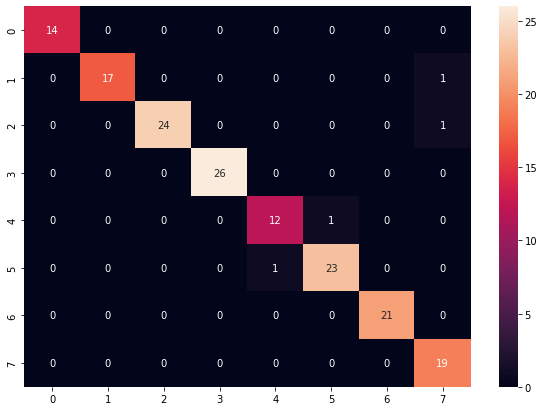

In [2]:
conf_matrix = np.load('trained_conf_matrix.npy')
# print(conf_matrix)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(conf_matrix, index = [i for i in range(8)],
                  columns = [i for i in range(8)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)